# This notebook calculates the Fisher matrix for various primordial bispectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from powerspectrum import *
from bispectra import *
from scipy import interpolate
from joblib import Parallel, delayed
import vegas

plt.rcParams.update({'font.size': 12})

In [2]:
print(A,As,ns,P(1))

4.1562878053867504e-08 2.1056e-09 0.9665 3.759422255898631e-08


they are in `powerspectrum`, $A = 2\pi^2 A_s$.

$P(k) = 0.05 A^{(1-n_s)} k^{(n_s-4)}$ .

In [3]:
zs,rs = np.genfromtxt("comovingD.dat").T
rhigh = rs[-1]
rlow = rs[0]
VzTotal = 4.*np.pi/3. * (rhigh**3-rlow**3)


rofz = interpolate.interp1d(zs,rs)

In [8]:
def FisherIntegrand(k,S1,S2,clockint,mu,alpha0):
    
    kmin = 0.01
    kmax = 10
    
    k1 = kmin + (kmax-kmin)*k[:,0]
    k2 = k1/2 + k1/2*k[:,1]
    k3min = np.fmax(kmin,k1-k2)
    k3max = k2-k3min
    k3 = k3min + k3max*k[:,2]
    
    P1 = P(k1)
    P2 = P(k2)
    P3 = P(k3)
    
    if S1==0:
        B1 = BLocal(P1,P2,P3)
    elif S1==1:
        B1 = BEquil(P1,P2,P3)
    elif S1==2:
        B1 = BOrtho(P1,P2,P3)
    elif S1==3:
        if clockint=='clock':
            B1 = BClockVec(k1,k2,k3,mu,alpha0)
        elif clockint=='int':
            B1 = BIntVec(k1,k2,k3,mu,alpha0)
        
    if S2==S1:
        B2 = B1
        
    elif S2==0:
        B2 = BLocal(P1,P2,P3)
    elif S2==1:
        B2 = BEquil(P1,P2,P3)
    elif S2==2:
        B2 = BOrtho(P1,P2,P3)
    elif S2==3:
        if clockint=='clock':
            B2 = BClockVec(k1,k2,k3,mu,alpha0)
        elif clockint=='int':
            B2 = BIntVec(k1,k2,k3,mu,alpha0)

    dvol = k1 * k2 * k3 * (kmax-kmin) * k1/2 * k3max

    BB = B1*B2
    
    Fish = BB /P1/P2/P3 * dvol

    return VzTotal * Fish / np.pi / (2*np.pi)**3


def Fisher(S1,S2,clockint=None,mu=None,alpha0=None,rtol=1e-3):
    
    @vegas.batchintegrand
    def integrandbatch(k):
        return FisherIntegrand(k,S1,S2,clockint,mu,alpha0)

    integ = vegas.Integrator(3*[[0,1]])
    pre = integ(integrandbatch,nitn=10,neval=1e6,rtol=rtol)
    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)

    return results.mean
%time Fisher(0,0)

CPU times: user 1.08 s, sys: 82.7 ms, total: 1.16 s
Wall time: 1.16 s


1417082.9222123271

## Calculate the Fisher matrix for the common primordial shapes (local, equilateral and orthogonal)

In [5]:
FishPrimDat = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Fisher)(i,j,rtol=1e-4) for i in range(3) for j in range(i,3)]))

FishPrim = np.zeros((3,3))

a=0
for i in range(3):
    for j in range(i,3):
        FishPrim[i,j] = FishPrim[j,i] = FishPrimDat[a]
        a+=1
        
FishPrim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.


[1636381245.400625] [pg-node165:5700 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1636381245.400662] [pg-node165:5700 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1636381245.420457] [pg-node165:5700 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1636381245.420468] [pg-node165:5700 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1636381245.426944] [pg-node165:5700 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1636381245.426957] [pg-node165:5700 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1636381245.436185] [pg-node165:5700 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.1s finished


array([[ 5.62232060e+10,  2.37388734e+09, -3.77150141e+09],
       [ 2.37388734e+09,  1.20500069e+09,  3.20344784e+08],
       [-3.77150141e+09,  3.20344784e+08,  2.26142579e+09]])

### Below are the estimated error bars for the three common shapes and their overlaps

In [8]:
np.diag(FishPrim)**(-1/2)

array([4.21726791e-06, 2.88086279e-05, 2.10248940e-05])

In [9]:
[FishPrim[i,j]/np.sqrt(FishPrim[i,i]*FishPrim[j,j]) for i in range(3) for j in range(i+1,3)]

[0.28846699758394506, -0.33441448862170325, 0.19401308049651134]

## Now calculate the clock template

In [18]:
mus = np.linspace(0.01,8,75)
FishClock1Dat = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Fisher)(i,3,'clock',mu,10) for mu in mus for i in range(4)]))
FishClock2Dat = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Fisher)(i,3,'clock',mu,2)  for mu in mus for i in range(4)]))

FishClock1 = np.zeros((len(mus),4,4))
FishClock2 = np.zeros((len(mus),4,4))

FishClock1[:,:3,:3] = FishPrim
FishClock2[:,:3,:3] = FishPrim

a=0
for mui in range(len(mus)):
    for i in range(4):
        FishClock1[mui,i,-1] = FishClock1[mui,-1,i] = FishClock1Dat[a]
        FishClock2[mui,i,-1] = FishClock2[mui,-1,i] = FishClock2Dat[a]
        a+=1
        
FishClock1Inv = np.linalg.inv(FishClock1)
FishClock2Inv = np.linalg.inv(FishClock2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 277 out of 300 | elapsed:   23.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.6s finished


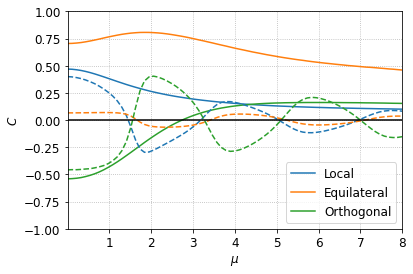

In [28]:
plt.plot(mus,FishClock2[:,-1,0]/np.sqrt(FishClock2[:,-1,-1]*FishClock2[:,0,0]),'-',label='Local')
plt.plot(mus,FishClock2[:,-1,1]/np.sqrt(FishClock2[:,-1,-1]*FishClock2[:,1,1]),'-',label='Equilateral')
plt.plot(mus,FishClock2[:,-1,2]/np.sqrt(FishClock2[:,-1,-1]*FishClock2[:,2,2]),'-',label='Orthogonal')
plt.gca().set_prop_cycle(None)
plt.plot(mus,FishClock1[:,-1,0]/np.sqrt(FishClock1[:,-1,-1]*FishClock1[:,0,0]),'--')
plt.plot(mus,FishClock1[:,-1,1]/np.sqrt(FishClock1[:,-1,-1]*FishClock1[:,1,1]),'--')
plt.plot(mus,FishClock1[:,-1,2]/np.sqrt(FishClock1[:,-1,-1]*FishClock1[:,2,2]),'--')

plt.ylabel("$C$")
plt.xlabel("$\\mu$")
plt.plot([0,8],[0,0],color='k')
plt.ylim(-1,1)
plt.xlim(mus[0],mus[-1])
plt.grid(linestyle=":")
plt.legend(loc="lower right")
plt.savefig("BClockOverlap.pdf",format='pdf',bbox_inches = 'tight')
plt.show()

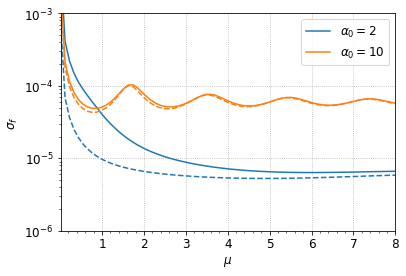

In [29]:
plt.semilogy(mus,FishClock2Inv[:,-1,-1]**(1./2.),'-',label='$\\alpha_{0} = 2$')
plt.semilogy(mus,FishClock1Inv[:,-1,-1]**(1./2.),'-',label='$\\alpha_{0} = 10$')
plt.gca().set_prop_cycle(None)
plt.semilogy(mus,FishClock2[:,-1,-1]**(-1./2.),'--')
plt.semilogy(mus,FishClock1[:,-1,-1]**(-1./2.),'--')



plt.xlabel("$\\mu$")
plt.ylabel("$\\sigma_f$")
plt.grid(linestyle=":")
plt.legend()
plt.xlim(mus[0],mus[-1])
plt.minorticks_on()
plt.ylim(1e-6,1e-3)
plt.savefig('BClockError.pdf',format='pdf',bbox_inches = 'tight')
plt.show()

## Now calculate the intermediate template

In [22]:
nus = np.linspace(0,1.5,35)
FishInt1Dat = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Fisher)(i,3,'int',mu,10,rtol=1e-4) for mu in nus for i in range(4)]))
FishInt2Dat = np.array(Parallel(n_jobs=-1,verbose=1)([delayed(Fisher)(i,3,'int',mu,2,rtol=1e-4)  for mu in nus for i in range(4)]))

FishInt1 = np.zeros((len(nus),4,4))
FishInt2 = np.zeros((len(nus),4,4))

FishInt1[:,:3,:3] = FishPrim
FishInt2[:,:3,:3] = FishPrim

a=0
for mui in range(len(nus)):
    for i in range(4):
        FishInt1[mui,i,-1] = FishInt1[mui,-1,i] = FishInt1Dat[a]
        FishInt2[mui,i,-1] = FishInt2[mui,-1,i] = FishInt2Dat[a]
        a+=1
        
FishInt1Inv = np.linalg.inv(FishInt1)
FishInt2Inv = np.linalg.inv(FishInt2)

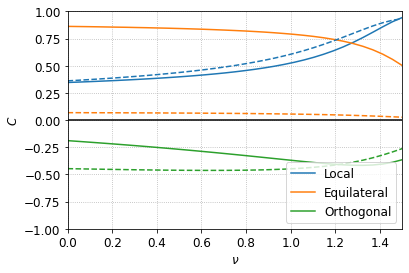

In [30]:
plt.plot(nus,FishInt2[:,-1,0]/np.sqrt(FishInt2[:,-1,-1]*FishInt2[:,0,0]),'-',label='Local')
plt.plot(nus,FishInt2[:,-1,1]/np.sqrt(FishInt2[:,-1,-1]*FishInt2[:,1,1]),'-',label='Equilateral')
plt.plot(nus,FishInt2[:,-1,2]/np.sqrt(FishInt2[:,-1,-1]*FishInt2[:,2,2]),'-',label='Orthogonal')
plt.gca().set_prop_cycle(None)
plt.plot(nus,FishInt1[:,-1,0]/np.sqrt(FishInt1[:,-1,-1]*FishInt1[:,0,0]),'--')
plt.plot(nus,FishInt1[:,-1,1]/np.sqrt(FishInt1[:,-1,-1]*FishInt1[:,1,1]),'--')
plt.plot(nus,FishInt1[:,-1,2]/np.sqrt(FishInt1[:,-1,-1]*FishInt1[:,2,2]),'--')

plt.ylabel("$C$")
plt.xlabel("$\\nu$")
plt.plot([0,8],[0,0],color='k')
plt.ylim(-1,1)
plt.xlim(nus[0],nus[-1])
plt.grid(linestyle=":")
plt.legend(loc="lower right")
plt.savefig("BIntOverlap.pdf",format='pdf',bbox_inches = 'tight')
plt.show()

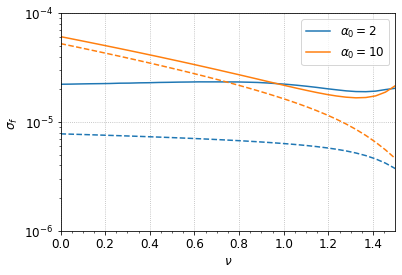

In [31]:
plt.semilogy(nus,FishInt2Inv[:,-1,-1]**(1./2.),'-',label='$\\alpha_{0} = 2$')
plt.semilogy(nus,FishInt1Inv[:,-1,-1]**(1./2.),'-',label='$\\alpha_{0} = 10$')
plt.gca().set_prop_cycle(None)
plt.semilogy(nus,FishInt2[:,-1,-1]**(-1./2.),'--')
plt.semilogy(nus,FishInt1[:,-1,-1]**(-1./2.),'--')



plt.xlabel("$\\nu$")
plt.ylabel("$\\sigma_f$")
plt.grid(linestyle=":")
plt.legend()
plt.xlim(nus[0],nus[-1])
plt.minorticks_on()
plt.ylim(1e-6,1e-4)
plt.savefig('BIntError.pdf',format='pdf',bbox_inches = 'tight')
plt.show()